<div align="center"> 

# **"TTE Conversion from R to Python (TTE-v1)"**

</div>

<div align="justify"> 

### **Python Library Imports**

</div>

In [26]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from dataclasses import dataclass
from typing import Optional, List, Dict, Union

<div align="justify"> 

### <span style="color:rgb(255, 0, 149);">**Step 1: Define the Estimand**</span>
Specify the type of effect you want to estimate, such as ***intention-to-treat (ITT)*** or ***per-protocol (PP)***. This determines how treatment adherence is handled in the analysis.

</div>

<div align="justify"> 

##### <span style="color:rgb(0, 207, 121);">**"Why are we creating folders for *'trial_pp'* and *'trial_itt'*?"**</span>
The analysis involves saving results or intermediate files specific to each estimand (Per-Protocol (PP) and Intention-to-Treat (ITT)). These folders are likely used to organize and store **outputs generated during the analysis process**. Here's a brief breakdown:

1. **Organizing Results:** Different estimands (PP and ITT) may produce different results or outputs. Creating separate folders helps keep the results organized and avoids mixing files.
2. **Reproducibility:** Saving intermediate files (e.g., datasets, models, or plots) allows you to revisit or reproduce the analysis later without rerunning everything.
3. **Comparison:** By storing results for PP and ITT separately, you can easily compare the outcomes of the two estimands.
4. **Scalability:** If the analysis involves multiple steps or iterations, having dedicated folders makes it easier to manage and scale the workflow.

</div>

In [27]:
# Step 1: Specify the estimand
trial_pp = {"estimand": "PP"}  # Per-protocol
trial_itt = {"estimand": "ITT"}  # Intention-to-treat

# Step 2: Define the base directory as "./Dataset"
base_dir = "../Datasets"

# Step 3: Create directories to save files
trial_pp_dir = os.path.join(base_dir, "trial_pp")
trial_itt_dir = os.path.join(base_dir, "trial_itt")

# Create the directories (including the base directory if it doesn't exist)
os.makedirs(trial_pp_dir, exist_ok=True)
os.makedirs(trial_itt_dir, exist_ok=True)

# Print the paths for verification
print(f"Per-Protocol (PP) directory: {trial_pp_dir}")
print(f"Intention-to-Treat (ITT) directory: {trial_itt_dir}")

Per-Protocol (PP) directory: ../Datasets\trial_pp
Intention-to-Treat (ITT) directory: ../Datasets\trial_itt


<div align="justify"> 

### <span style="color:rgb(255, 0, 149);">**Step 2: Prepare Observational Data**</span>
Ensure your dataset includes columns for treatment, outcomes, and eligibility criteria. This step is crucial for aligning your observational data with the hypothetical RCT you are emulating.

##### <span style="color:rgb(0, 207, 121);">**Code Snippet Process Breakdown:**</span>

1. Here we simply load and display the first five rows of the dataset from the 'data_censored.csv' file to verify if it has been loaded correctly. 
2. Given the setData() function, we define an object named **'trial'** (a dictionary) to associate and assign with a dataset and its specific columns.

    The function takes the following arguments: </br>
   - **trial:** The dictionary to be configured. </br>
   - **data:** The dataset (a pandas DataFrame). </br>
   - **id_col:** The column name for the unique identifier (e.g., "id"). </br>
   - **period_col:** The column name for the time period (e.g., "period"). </br>
   - **treatment_col:** The column name for the treatment indicator (e.g., "treatment"). </br>
   - **outcome_col:** The column name for the outcome variable (e.g., "outcome"). </br>
   - **eligible_col:** The column name for the eligibility indicator (e.g., "eligible").  </br>

3. We then configure the **'trial_pp'** by creating an empty dictionary out of it that shall represent the Per-Protocol (PP) trial. The set_data function is called to configure trial_pp with the dataset (data_censored) and the specified columns (id, period, treatment, outcome, eligible).
4. Then configure the **'trial_itt'** by creating an empty dictionary out of it that shall represent the Intention-To-Treat (ITT) trial. The set_data function is called to configure trial_itt with the same dataset and columns as trial_pp.
5. We print the configured 'trial_pp' and 'trial_itt' objects to verify the content of these dictionaries.

</div>

In [28]:
# Step 1: Load the dataset from "../Dataset/data_censored.csv"
dataset_path = "../Datasets/data_censored.csv"
data_censored = pd.read_csv(dataset_path)

# Display the first few rows of the dataset
print("Loaded Dataset:")
print(data_censored.head())

# Step 2: Define a function to set data for analysis
def set_data(trial, data, id_col, period_col, treatment_col, outcome_col, eligible_col):
    """
    Configures the trial object with the specified dataset and columns.
    """
    trial['data'] = data
    trial['id'] = id_col
    trial['period'] = period_col
    trial['treatment'] = treatment_col
    trial['outcome'] = outcome_col
    trial['eligible'] = eligible_col
    return trial

# Step 3: Configure trial_pp (Per-Protocol)
trial_pp = {}
trial_pp = set_data(
    trial_pp,
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible"
)

# Step 4: Configure trial_itt (Intention-to-Treat)
trial_itt = {}
trial_itt = set_data(
    trial_itt,
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible"
)

# Step 5: Print the configured trial objects
print("\nPer-Protocol (PP) Trial:")
print(trial_pp)

print("\nIntention-to-Treat (ITT) Trial:")
print(trial_itt)

Loaded Dataset:
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  

Per-Protocol (PP) Trial:
{'data':      id  period  treatment  x1        x2  x3        x4  age     age_s  \
0     1       0          1   1  1.146148   0  0.734203   36  0.083333   
1     1       1          1   1  0.002200   0  0.734203   37  0.166667   
2     1       2          1   0 -0.481762   0  0.734203   38  0.250000   
3     1       3          1   0  

<div align="justify"> 

##### <span style="color:rgb(0, 207, 121);">**Miscellaneuous: Visualizing the Initial and Current Dictionaries**</span>

I wanted to see for myself what the current dictionaries look like on a bar graph of the properties: treatment, outcome, and elligible. Right now, **they look the same and why is that?** Both 'trial_pp' and 'trial_itt' are both using the same dataset which is 'data_censored.csv'. As of right now, we currently have no data filtering or any modification applied to the dataset to be able to have a distiction between the two. **We are simply using the raw data as-is.**


</div>

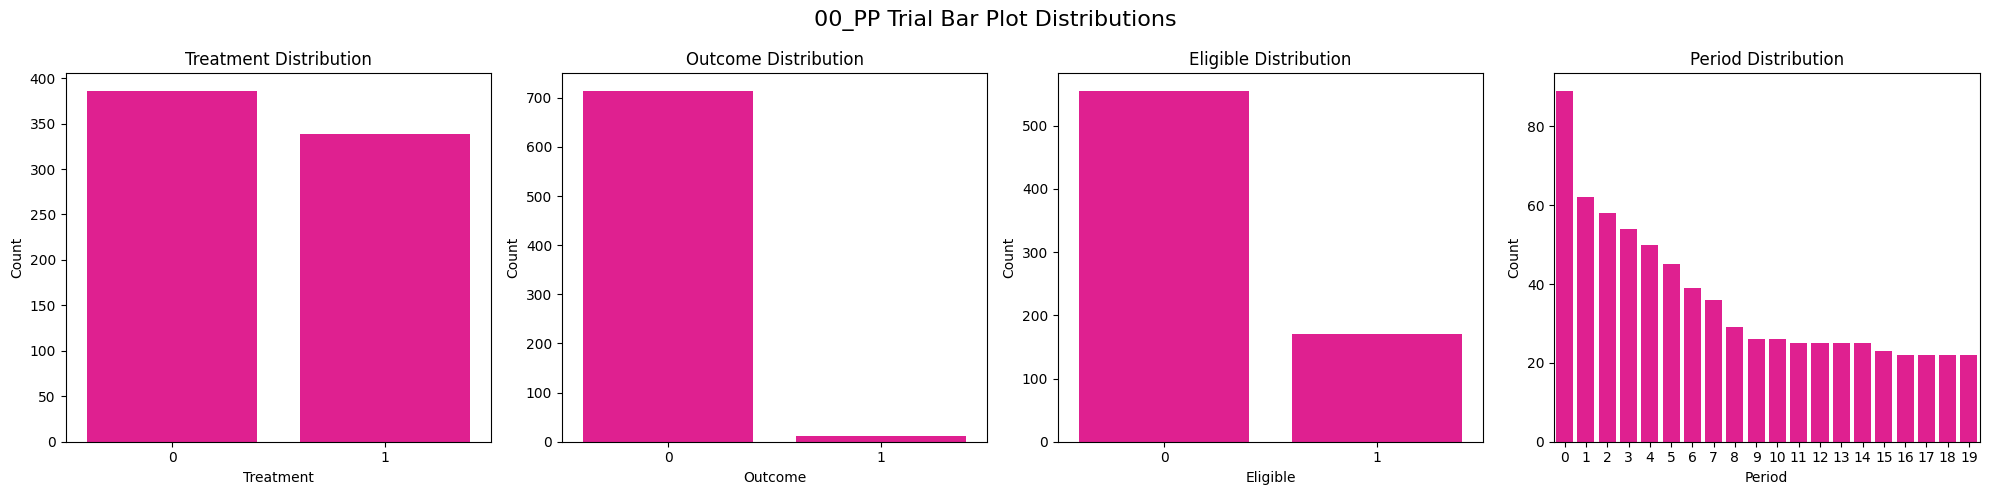

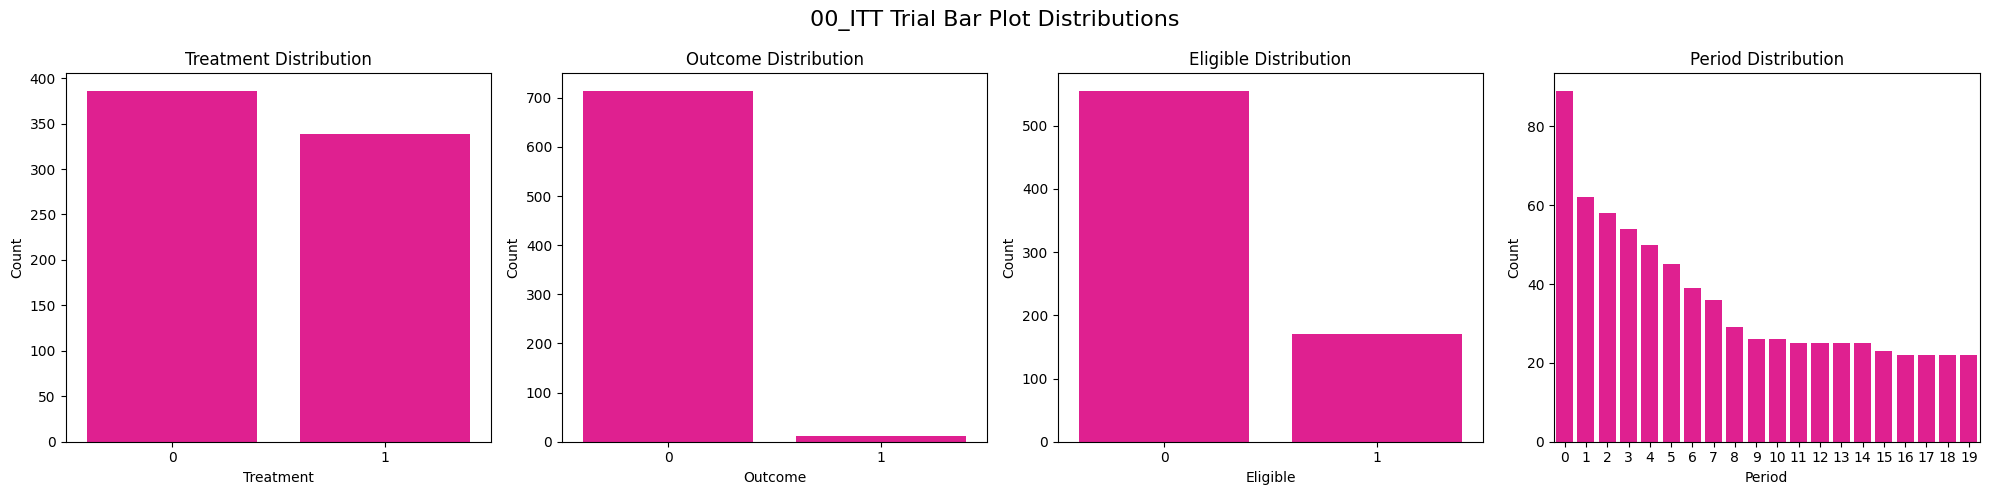

In [ ]:
# Define the custom color
custom_color = (255/255, 0/255, 149/255)  # PINK
# custom_color = (0/255, 207/255, 121/255)  # GREEN (too bright, not good on white bg)

# Function to plot distributions
def plot_distributions(trial, title, save_dir):
    data = trial['data']
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # 1 row, 4 columns
    fig.suptitle(title, fontsize=16)

    # Plot treatment distribution
    sns.countplot(x=trial['treatment'], data=data, ax=axes[0], color=custom_color)
    axes[0].set_title("Treatment Distribution")
    axes[0].set_xlabel("Treatment")
    axes[0].set_ylabel("Count")

    # Plot outcome distribution
    sns.countplot(x=trial['outcome'], data=data, ax=axes[1], color=custom_color)
    axes[1].set_title("Outcome Distribution")
    axes[1].set_xlabel("Outcome")
    axes[1].set_ylabel("Count")

    # Plot eligible distribution
    sns.countplot(x=trial['eligible'], data=data, ax=axes[2], color=custom_color)
    axes[2].set_title("Eligible Distribution")
    axes[2].set_xlabel("Eligible")
    axes[2].set_ylabel("Count")

    # Plot period distribution
    sns.countplot(x=trial['period'], data=data, ax=axes[3], color=custom_color)
    axes[3].set_title("Period Distribution")
    axes[3].set_xlabel("Period")
    axes[3].set_ylabel("Count")

    plt.tight_layout()

    # Save the figure
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  # Create the directory if it doesn't exist
    save_path = os.path.join(save_dir, f"{title.replace(' ', '_')}.png")
    plt.savefig(save_path, bbox_inches='tight')  # Save the plot

    plt.show()

# Visualize Per-Protocol (PP) Trial
plot_distributions(trial_pp, "00_PP Trial Bar Plot Distributions", "../Datasets/trial_pp")

# Visualize Intention-to-Treat (ITT) Trial
plot_distributions(trial_itt, "00_ITT Trial Bar Plot Distributions", "../Datasets/trial_itt")

<div align="justify"> 

### <span style="color:rgb(255, 0, 149);">**Step 3: Address Censoring Mechanisms**</span>
Use **inverse probability of censoring weights (IPCW)** to adjust for biases due to treatment switching and informative censoring. This involves fitting separate models to calculate these weights.

</div>

<div align="justify"> 

### <span style="color:rgb(255, 0, 149);">**Step 4: Expand Observational Data into Trial Datasets**</span>
Use predefined expansion options to create trial-specific datasets from your observational data. This step involves transforming your data into a format that mimics a sequence of RCTs.

</div>

<div align="justify"> 

### <span style="color:rgb(255, 0, 149);">**Step 5: Fit Marginal Structural Models (MSMs)**</span>
MSMs are used to estimate the causal effects of treatments. These models adjust for time-varying confounders and provide estimates of treatment effects over time.

</div>

<div align="justify"> 

### <span style="color:rgb(255, 0, 149);">**Step 6: Generate Predictions and Visualizations**</span>
Predict survival probabilities and cumulative incidences for different treatment scenarios. Visualize these predictions to illustrate how survival rates differ over time between treatment groups, facilitating meaningful inference about treatment effects.

</div>